### Data Preprocessing - Image Handling

This file will serve to handle the preprocessing of images, specifically turn them into tensors to pass into a convolutional neural network and achieve embeddings.

#### Very important: Because of the size of the training and validation folders that contain the images, we were unable to upload them to the github repository. It is essential that the images need to be saved locally with this notebook in a folder labeled "train" and "test" which can be achieved from Kaggle.


```text
Data/
├── images/
|       ├── train/
        ├── val/
├── fairface_label_train.csv
└── fairface_label_val.csv



In [1]:
#Code Block 1
## import libraries

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Code Block 2
## load the data

### labels
train_labels = pd.read_csv("data/fairface_label_train.csv")
test_labels = pd.read_csv("data/fairface_label_val.csv")

train_labs = pd.read_csv("data/fairface_label_train_cleaned.csv")
test_labs = pd.read_csv("data/fairface_label_val_cleaned.csv")

display(train_labels.head())
display(test_labels.head())
display(train_labs.head())
display(test_labs.head())

,file,age,gender,race,service_test
0,train/1.jpg,50-59,Male,East Asian,True
1,train/2.jpg,30-39,Female,Indian,False
2,train/3.jpg,3-9,Female,Black,False
3,train/4.jpg,20-29,Female,Indian,True
4,train/5.jpg,20-29,Female,Indian,True


,file,age,gender,race,service_test
0,val/1.jpg,3-9,Male,East Asian,False
1,val/2.jpg,50-59,Female,East Asian,True
2,val/3.jpg,30-39,Male,White,True
3,val/4.jpg,20-29,Female,Latino_Hispanic,True
4,val/5.jpg,20-29,Male,Southeast Asian,False


,file,age,gender,race,race_gender
0,train/1.jpg,50-59,male,east asian,east asian_male
1,train/2.jpg,30-39,female,indian,indian_female
2,train/3.jpg,3-9,female,black,black_female
3,train/4.jpg,20-29,female,indian,indian_female
4,train/5.jpg,20-29,female,indian,indian_female


,file,age,gender,race,race_gender
0,val/1.jpg,3-9,male,east asian,east asian_male
1,val/2.jpg,50-59,female,east asian,east asian_female
2,val/3.jpg,30-39,male,white,white_male
3,val/4.jpg,20-29,female,latino_hispanic,latino_hispanic_female
4,val/5.jpg,20-29,male,southeast asian,southeast asian_male


In [3]:
#Code Block 3
## transform the images
from torchvision import transforms

image_transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ]
)

In [4]:
#Code Block 4
## create the custom dataset class
from torch.utils.data import Dataset
from PIL import Image

class FairFaceDataset(Dataset):
    def __init__(self, df, image_dir, transform = None):
        self.df = df.reset_index(drop = True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, "file"]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        race = self.df.loc[idx, "race"]
        gender = self.df.loc[idx, "gender"]
        race_gender = self.df.loc[idx, "race_gender"]

        return image, race, gender, race_gender
    

In [5]:
#Code Block 5
## create the training and validation datasets

train_dataset = FairFaceDataset(train_labs, "data/images", transform = image_transform)
test_dataset = FairFaceDataset(test_labs, "data/images", transform = image_transform)

print(len(train_dataset), len(test_dataset))

86744 10954


In [6]:
#Code Block 6
## visualize some images from the dataset
import torch

def show_images(dataset, n = 5):
    fig, axes = plt.subplots(1, n, figsize=(25, 4))

    for i in range(n):
        image, race, gender, race_gender = dataset[i]

        ## unnormalize the torches
        img = image.clone()
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)

        img = img.permute(1, 2, 0).numpy()

        axes[i].imshow(img)
        axes[i].set_title(f"{race}, {gender}, {race_gender}")
        axes[i].axis("off")

    plt.show()

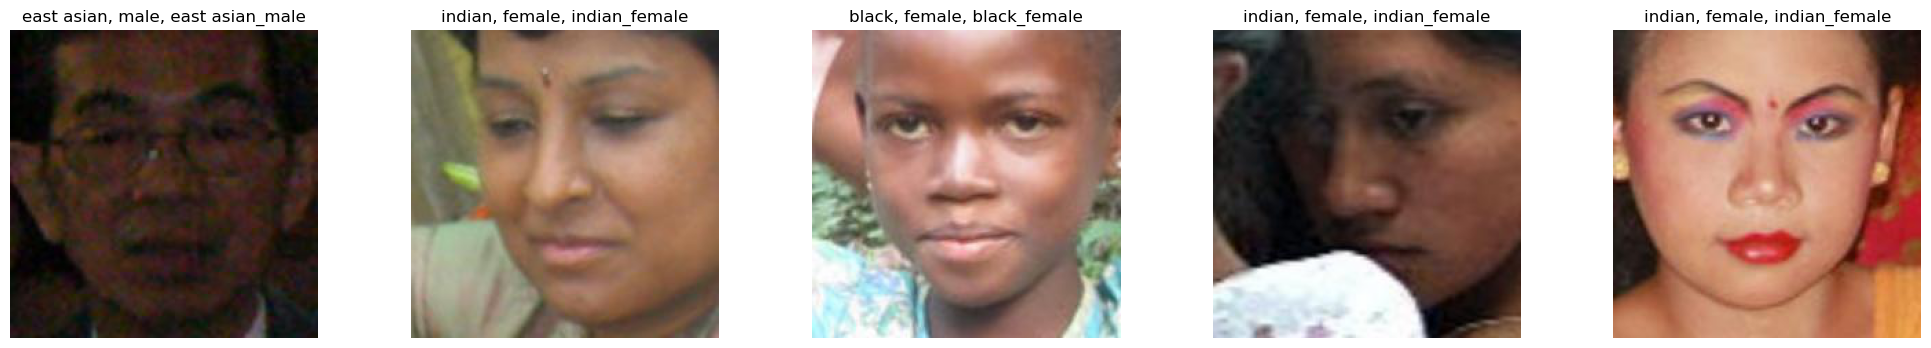

In [7]:
#Code Block 7
## show the images

show_images(train_dataset, n = 5)

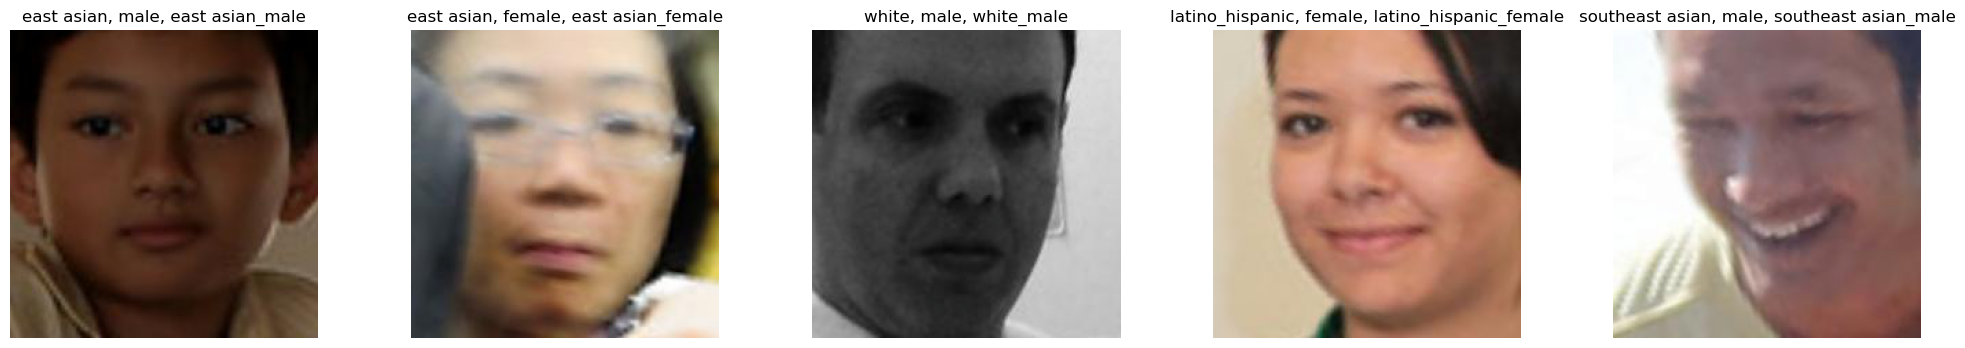

In [8]:
#Code Block 8
## show the images

show_images(test_dataset, n = 5)

In [9]:
#Code Block 9
## load the pretrained CNN
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(pretrained = True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # remove the final fully connected layer - classifier
resnet = resnet.to(device)
resnet.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [10]:
#Code Block 10
## build the data loaders
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size = 32,
    shuffle = False, #preserve order for label aligment
    num_workers = 0
)

test_loader = DataLoader(
    test_dataset,
    batch_size = 32,
    shuffle = False, #preserve order for label aligment
    num_workers = 0
)

In [13]:
#Code Block 11
## extract the embeddings from the CNN for decision tree classification
from tqdm import tqdm

def extract_embeddings(dataloader, model, device):
    all_embeddings = []
    all_race = []
    all_gender = []
    all_race_gender = []

    with torch.no_grad():
        for images, race, gender, race_gender in tqdm(dataloader):
            images = images.to(device)
            
            feats = model(images)
            feats = feats.view(feats.size(0), -1)  # flatten the features

            all_embeddings.append(feats.cpu().numpy())
            all_race.extend(race)
            all_gender.extend(gender)
            all_race_gender.extend(race_gender)

    embeddings = np.vstack(all_embeddings)

    df = pd.DataFrame(
        embeddings,
        columns = [f"feat_{i}" for i in range(embeddings.shape[1])]
    )

    df['race'] = all_race
    df['gender'] = all_gender
    df['race_gender'] = all_race_gender

    return df

In [14]:
#Code Block 12
## create the training and testing embeddings

train_embeddings = extract_embeddings(train_loader, resnet, device)
test_embeddings = extract_embeddings(test_loader, resnet, device)

print(train_embeddings.shape, test_embeddings.shape)

100%|██████████| 343/343 [02:41<00:00,  2.13it/s]

(86744, 515) (10954, 515)


In [15]:
#Code Block 13

display(train_embeddings.head())
test_embeddings.head()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511,race,gender,race_gender
0,0.843073,0.103579,0.224522,0.000000,0.778184,0.027723,0.454252,0.303014,0.029440,0.200618,...,0.150238,0.323468,0.784020,1.181147,0.422497,0.239257,0.723814,east asian,male,east asian_male
1,0.180621,1.292241,0.971825,0.132645,0.015272,0.305211,0.422381,0.379263,0.054428,0.007033,...,0.650830,2.343723,0.182173,0.085612,1.129795,0.638840,0.099425,indian,female,indian_female
2,0.012478,0.151712,0.666835,0.229115,0.108760,0.079838,0.191968,0.000000,0.269209,0.378046,...,0.322626,1.649574,0.019350,0.490857,0.762305,0.825264,0.454207,black,female,black_female
3,0.175503,0.309288,1.302044,0.065322,0.318755,0.151344,0.223482,0.075722,0.164445,0.174925,...,0.501732,0.948112,1.632882,0.479979,0.363495,0.169139,0.768004,indian,female,indian_female
4,0.066143,0.208480,1.062915,0.474760,0.000000,0.000000,0.041315,0.009158,0.053300,0.624211,...,0.697677,2.309969,0.987021,0.091093,0.343762,0.901343,0.149076,indian,female,indian_female


,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_505,feat_506,feat_507,feat_508,feat_509,feat_510,feat_511,race,gender,race_gender
0,0.065531,0.145638,0.666353,0.022759,0.020042,0.494037,0.391600,0.896950,0.297403,0.009280,...,0.562256,2.478459,0.285622,0.006262,1.124570,0.688017,0.039207,east asian,male,east asian_male
1,0.243451,1.143462,0.491546,0.010157,0.837501,0.255487,0.135047,0.386226,0.206483,0.125620,...,0.512902,1.975987,1.487281,0.463475,0.126805,0.581827,1.107382,east asian,female,east asian_female
2,2.700191,0.768331,0.186618,0.144938,0.226986,0.147554,0.203444,0.365457,0.118876,0.453851,...,1.817159,2.202756,0.292811,1.336264,0.928382,1.471213,1.068437,white,male,white_male
3,0.268805,0.398621,0.796091,0.180213,0.054708,0.198172,0.698923,0.067774,0.119012,0.025534,...,0.371233,2.206412,0.518856,0.860804,0.407948,0.261468,0.428787,latino_hispanic,female,latino_hispanic_female
4,1.209170,0.045833,0.066622,0.145954,0.043286,0.019625,0.327715,0.143074,0.195398,0.843317,...,1.100869,2.160444,0.204243,0.440574,0.637311,0.233427,1.096583,southeast asian,male,southeast asian_male


In [17]:
#Code Block 14
## recheck label imbalence

display(train_embeddings["race"].value_counts(normalize=True))
train_embeddings["gender"].value_counts(normalize=True)


race
white              0.190526
latino_hispanic    0.154097
indian             0.142016
east asian         0.141647
black              0.141024
southeast asian    0.124447
middle eastern     0.106244
Name: proportion, dtype: float64

gender
male      0.530135
female    0.469865
Name: proportion, dtype: float64

In [18]:
#Code Block 15
## save the embeddings for later use

train_embeddings.to_csv("data/train_embeddings.csv", index=False)
test_embeddings.to_csv("data/test_embeddings.csv", index=False)

### Next Steps

Once embeddings are created, we can:
*	Encode race or gender labels
*	Train the Decision Tree
*	Measure misclassification rates by subgroup

1.	Encode labels (race or gender as target)
2.	Train a Decision Tree classifier/KNN Classifier to predict race/gender using training embeddings ONLY
3.	Predict on validation embeddings
4.	Compute error rates by subgroup